In [1]:
!pip install statsmodels scikit-learn

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
file_path = '/content/main.csv.xlsx'  # Update this if your file name is different
data = pd.read_excel(file_path)

In [3]:
data_cleaned = data.dropna()
data_cleaned['Timestamp'] = pd.to_datetime(data_cleaned['Timestamp [ms]'], unit='ms')


In [4]:
data_cleaned['CPU_rolling_avg'] = data_cleaned['\tCPU usage [%]'].rolling(window=10).mean()
data_cleaned['Memory_rolling_avg'] = data_cleaned['\tMemory usage [KB]'].rolling(window=10).mean()


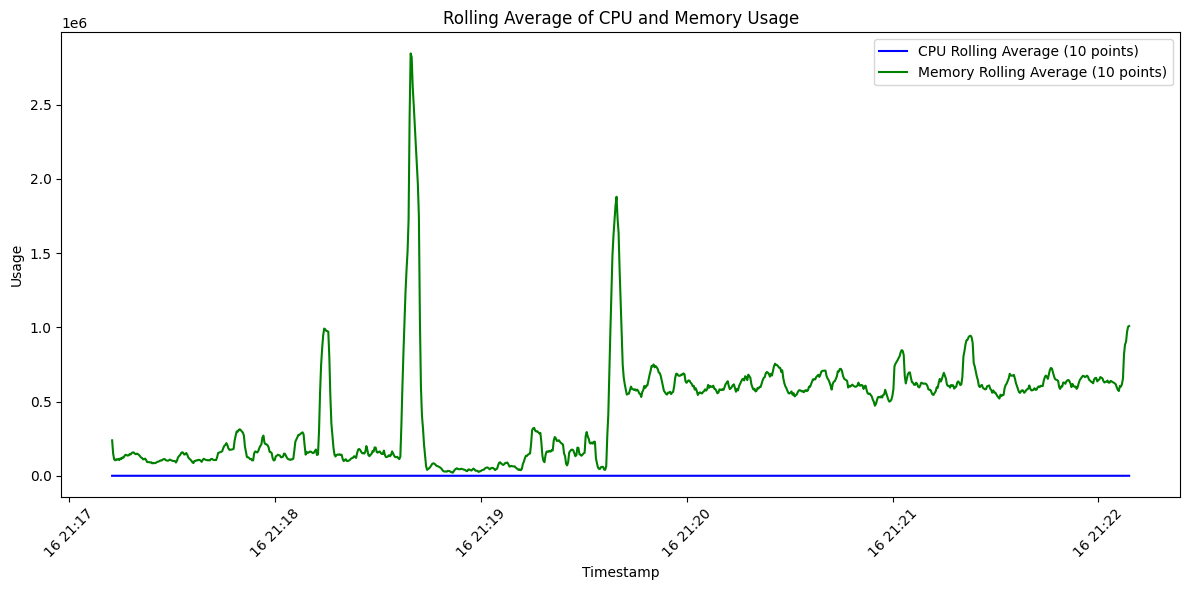

In [5]:
# Plot Rolling Averages
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned['Timestamp'], data_cleaned['CPU_rolling_avg'], color='blue', label='CPU Rolling Average (10 points)')
plt.plot(data_cleaned['Timestamp'], data_cleaned['Memory_rolling_avg'], color='green', label='Memory Rolling Average (10 points)')
plt.xlabel('Timestamp')
plt.ylabel('Usage')
plt.title('Rolling Average of CPU and Memory Usage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Feature selection (including multivariate features)
X = data_cleaned[['\tMemory usage [KB]', '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]',
                  '\tNetwork received throughput [KB/s]', '\tNetwork transmitted throughput [KB/s]', 'Memory_rolling_avg']]
y = data_cleaned['\tCPU usage [%]']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [8]:
y_pred = rf_model.predict(X_test)

# Performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.37681205627705633
R-squared: 0.9548331258621389
Root Mean Squared Error: 1.2440718401483808


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


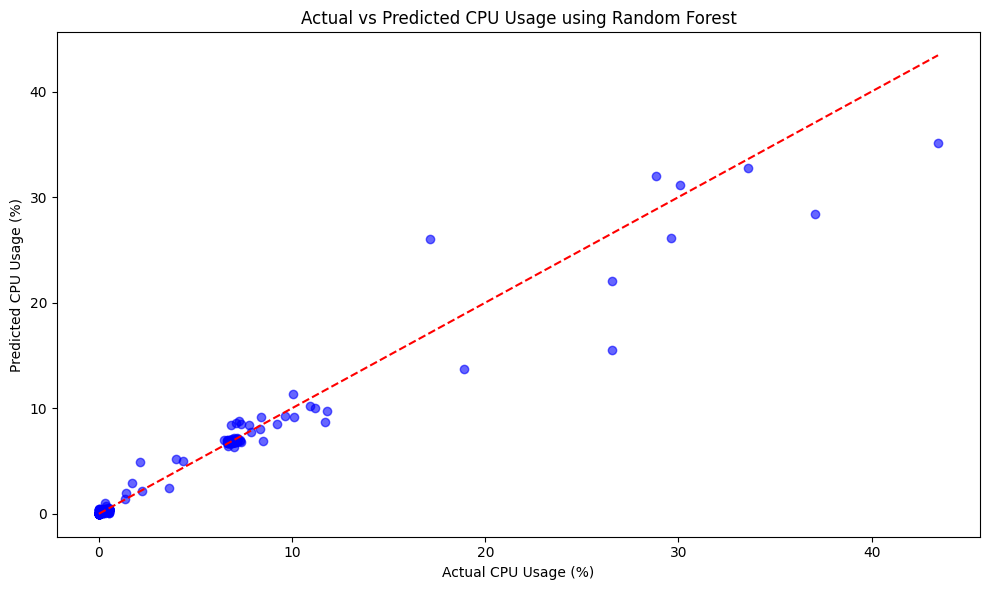

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal prediction line
plt.xlabel('Actual CPU Usage (%)')
plt.ylabel('Predicted CPU Usage (%)')
plt.title('Actual vs Predicted CPU Usage using Random Forest')
plt.tight_layout()
plt.show()

In [45]:
import pandas as pd
import numpy as np

# Generate synthetic clean data
def generate_synthetic_data(num_rows=50):
    # Create timestamps (daily timestamps for simplicity)
    timestamps = pd.date_range(start="2023-01-01", periods=num_rows, freq='D')

    # Simulate CPU utilization (between 0 and 1)
    cpu_utilization = np.random.uniform(0, 1, num_rows)

    # Simulate workload (between 100 and 500)
    workload = np.random.uniform(100, 500, num_rows)

    # Create DataFrame
    data = pd.DataFrame({
        'Timestamp': timestamps,
        'CPU Utilization': cpu_utilization,
        'Workload': workload
    })

    # Ensure no NaN values are in the data
    data = data.fillna(0)

    return data

# Generate synthetic data
data_cleaned1 = generate_synthetic_data(num_rows=50)

# Display the first few rows of the generated data
print(data_cleaned1.head())

# Initialize the environment and agent
class CloudEnvironment:
    """
    Simulated Cloud Environment with CPU utilization and workload data
    """
    def __init__(self, historical_data):
        self.data = historical_data
        self.current_step = 0
        self.state_size = len(historical_data.columns) - 1  # Excluding timestamp
        self.num_actions = 3  # Scale Up, Scale Down, Maintain

    def reset(self):
        self.current_step = 0
        return self.get_state(self.current_step)

    def get_state(self, step):
        state = self.data.iloc[step].drop(['Timestamp']).values  # Drop timestamp from state
        return state

    def step(self, action):
        current_state = self.get_state(self.current_step)

        # Simulate the effect of scaling resources
        if action == 0:  # Scale up
            reward = -current_state[0] + 0.5  # Penalty and reward for scaling up
        elif action == 1:  # Scale down
            reward = -current_state[0] - 0.5  # Penalty for scaling down
        else:  # Maintain
            reward = -abs(current_state[0] - 0.7)  # Penalize for deviating from target CPU usage

        self.current_step = (self.current_step + 1) % len(self.data)
        next_state = self.get_state(self.current_step)

        done = False
        return next_state, reward, done

class QLearningAgent:
    def __init__(self, state_size, num_actions):
        self.state_size = state_size
        self.num_actions = num_actions
        self.q_table = np.zeros((state_size, num_actions))  # Initialize Q-table with zeros
        self.learning_rate = 0.1
        self.discount_factor = 0.9
        self.exploration_rate = 1.0
        self.exploration_decay = 0.995
        self.min_exploration_rate = 0.1

    def choose_action(self, state):
        # Convert state to numpy array (ensure correct type)
        state = np.array(state, dtype=float)  # Ensure it's a numpy array of floats

        # Handle NaN values by replacing them with zero
        if np.any(np.isnan(state)):
            print("Warning: State contains NaN values. Replacing NaNs with zeros.")
            state = np.nan_to_num(state, nan=0.0)  # Replace NaN with 0

        # Compute state index safely
        state_index = int(np.clip(np.sum(state) % self.state_size, 0, self.state_size - 1))  # Get index within bounds

        # Exploration vs Exploitation
        if np.random.uniform(0, 1) < self.exploration_rate:
            return np.random.choice(self.num_actions)  # Explore: Random action
        else:
            return np.argmax(self.q_table[state_index])  # Exploit: Best known action

    def update_q_table(self, state, action, reward, next_state):
        # Ensure state and next_state are numpy arrays and handle NaN values
        state = np.array(state, dtype=float)
        next_state = np.array(next_state, dtype=float)

        # Handle NaN values by replacing them with zero
        if np.any(np.isnan(state)):
            print("Warning: State contains NaN values. Replacing NaNs with zeros.")
            state = np.nan_to_num(state, nan=0.0)  # Replace NaN with 0
        if np.any(np.isnan(next_state)):
            print("Warning: Next state contains NaN values. Replacing NaNs with zeros.")
            next_state = np.nan_to_num(next_state, nan=0.0)  # Replace NaN with 0

        # Convert state and next_state to discrete indices
        state_index = int(np.clip(np.sum(state) % self.state_size, 0, self.state_size - 1))
        next_state_index = int(np.clip(np.sum(next_state) % self.state_size, 0, self.state_size - 1))

        # Find the best action in the next state
        best_next_action = np.argmax(self.q_table[next_state_index])

        # Update Q-table using the Q-learning update rule
        self.q_table[state_index, action] += self.learning_rate * (
            reward + self.discount_factor * self.q_table[next_state_index, best_next_action] - self.q_table[state_index, action]
        )

    def decay_exploration_rate(self):
        if self.exploration_rate > self.min_exploration_rate:
            self.exploration_rate *= self.exploration_decay


def train_rl_model(environment, agent, episodes=5):
    for episode in range(episodes):
        state = environment.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            agent.update_q_table(state, action, reward, next_state)
            total_reward += reward
            state = next_state

            # Determine if the action was "good" or "bad"
            if reward > 0:
                action_feedback = "good"
            else:
                action_feedback = "bad"

            # Print action, reward, and feedback
            if action == 0:
                action_name = "Scale Up"
            elif action == 1:
                action_name = "Scale Down"
            else:
                action_name = "Maintain"

            print(f"Episode {episode + 1}/{episodes}, Action: {action_name}, Reward: {reward:.4f}, Action Feedback: {action_feedback}")

        agent.decay_exploration_rate()
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.4f}, Exploration Rate: {agent.exploration_rate:.4f}")


# Initialize and train RL model
env = CloudEnvironment(data_cleaned1)
agent = QLearningAgent(state_size=2, num_actions=3)  # 2 state features (CPU Utilization, Workload), 3 actions




   Timestamp  CPU Utilization    Workload
0 2023-01-01         0.448917  266.997884
1 2023-01-02         0.228084  200.238138
2 2023-01-03         0.349785  215.056190
3 2023-01-04         0.884333  168.997746
4 2023-01-05         0.017285  364.347973


In [46]:
agent = QLearningAgent(state_size=len(X.columns), num_actions=3)

In [47]:

train_rl_model(env, agent)

Streaming output truncated to the last 5000 lines.
Episode 1/5, Action: Scale Up, Reward: -0.1959, Action Feedback: bad
Episode 1/5, Action: Scale Down, Reward: -0.9789, Action Feedback: bad
Episode 1/5, Action: Scale Up, Reward: -0.4714, Action Feedback: bad
Episode 1/5, Action: Scale Up, Reward: 0.4324, Action Feedback: good
Episode 1/5, Action: Scale Down, Reward: -1.0811, Action Feedback: bad
Episode 1/5, Action: Maintain, Reward: -0.2603, Action Feedback: bad
Episode 1/5, Action: Scale Up, Reward: -0.0176, Action Feedback: bad
Episode 1/5, Action: Maintain, Reward: -0.6673, Action Feedback: bad
Episode 1/5, Action: Scale Down, Reward: -1.0236, Action Feedback: bad
Episode 1/5, Action: Maintain, Reward: -0.0993, Action Feedback: bad
Episode 1/5, Action: Scale Down, Reward: -0.8617, Action Feedback: bad
Episode 1/5, Action: Maintain, Reward: -0.4928, Action Feedback: bad
Episode 1/5, Action: Maintain, Reward: -0.3303, Action Feedback: bad
Episode 1/5, Action: Scale Up, Reward: -0.03

KeyboardInterrupt: 

In [48]:
future_days = 5
future_data = data_cleaned.tail(future_days)

# Predict CPU usage for the next 5 days using Random Forest model
X_future = future_data[['\tMemory usage [KB]', '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]',
                        '\tNetwork received throughput [KB/s]', '\tNetwork transmitted throughput [KB/s]', 'Memory_rolling_avg']]
future_cpu_pred = rf_model.predict(X_future)

print("Predicted CPU Usage for the Next 5 Days:", future_cpu_pred)

Predicted CPU Usage for the Next 5 Days: [ 8.04685714 11.20166667  8.74733333  7.05045238  6.94778571]


# New Section